In [1]:
import amsterdm
from amsterdm.burst import Burst
import amsterdm.core
import amsterdm.plot as dmplot

In [2]:
burst = Burst.fromfile("amsterdm-sim.fits")

'nchans' not found in header; determining from the data


For the data, at the moment the assumed order of dimensions is always (samples, polarization, frequency). If the data is two-dimensional, the polarization channel dimension is assumed to be 1.

In [3]:
burst.data.shape

(20000, 4, 128)

The header is obtained from the data file, with some additions (and new keywords, such as `POLCHAN`); note how one keyword was not found in the data file, but could be inferred from the data itself. If a missing keyword can not be inferred, a `ValueError` would be raised instead.

The header itself is a FITS header. At the moment, this is only the case for data read in from a FITS file. If the input is a Filterbank file, the data will be a Python `dict`, so comments are missing. Otherwise, both styles of headers behave the same, as a basic dictionary in Python.

In [4]:
burst.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  128                                                  
NAXIS2  =                    4                                                  
NAXIS3  =                20000                                                  
OBJECT  = 'N/A     '           / source name                                    
SRCNAME = 'N/A     '           / source name                                    
COH_DM  =               123.45 / coherent dispersion measure                    
FCHAN1  =                 1400 / frequency of channel 1 [MHz]                   
FOFF    =                   -2 / frequency width of a channel                   
FANCHOR = 'mid     '           / anchor point on channel (top, bottom, mid)     
BADCHAN = '' / comma-separat

Create a first waterfall plot with a disperson measure (DM) of 0, a background section of 0 – 0.333 and 0.666 – 1 (see `amsterdm.constants`) and no bad channels.
Since the median is used by default in calculating the background (and therefore the bandpass), having part of the background overlap with the actual burst is unlikely to cause problems, and may still provide a good estimate of the background.

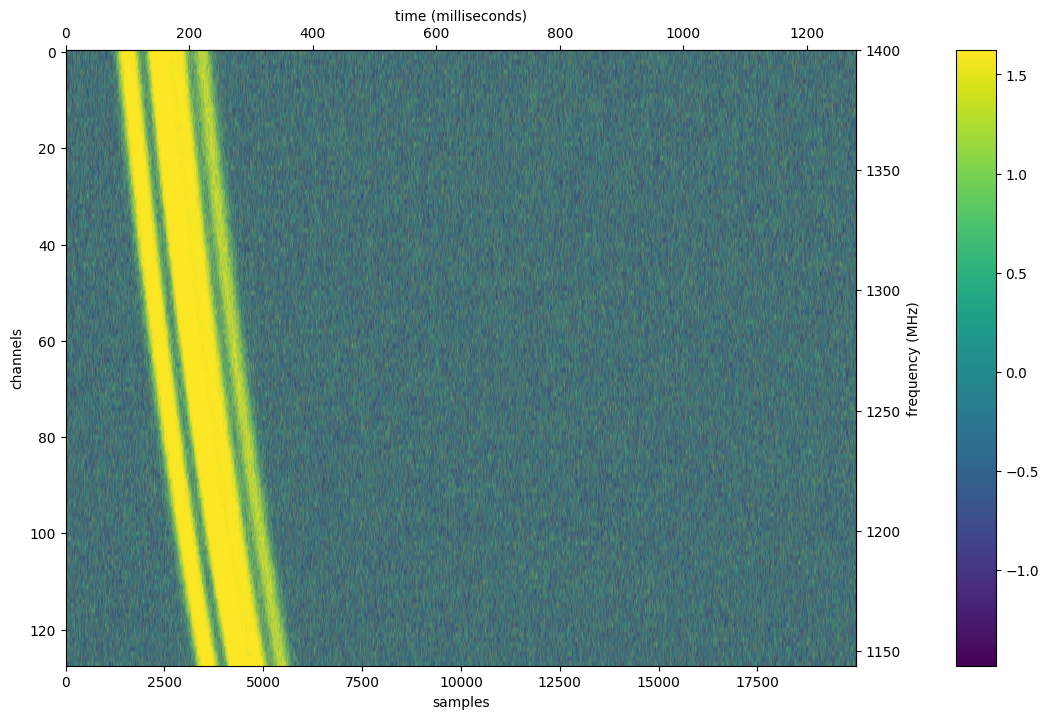

In [5]:
dmplot.waterfall(burst);

Now correct for the (correct) dispersion measure, flag some channels and set the background range to use only the right part of the dynamical spectrum to calculate the background value (note: dedispersion is done first, before the background calculation; this means that pixels from the left of the burst get rotated onto the right of the full spectrum).

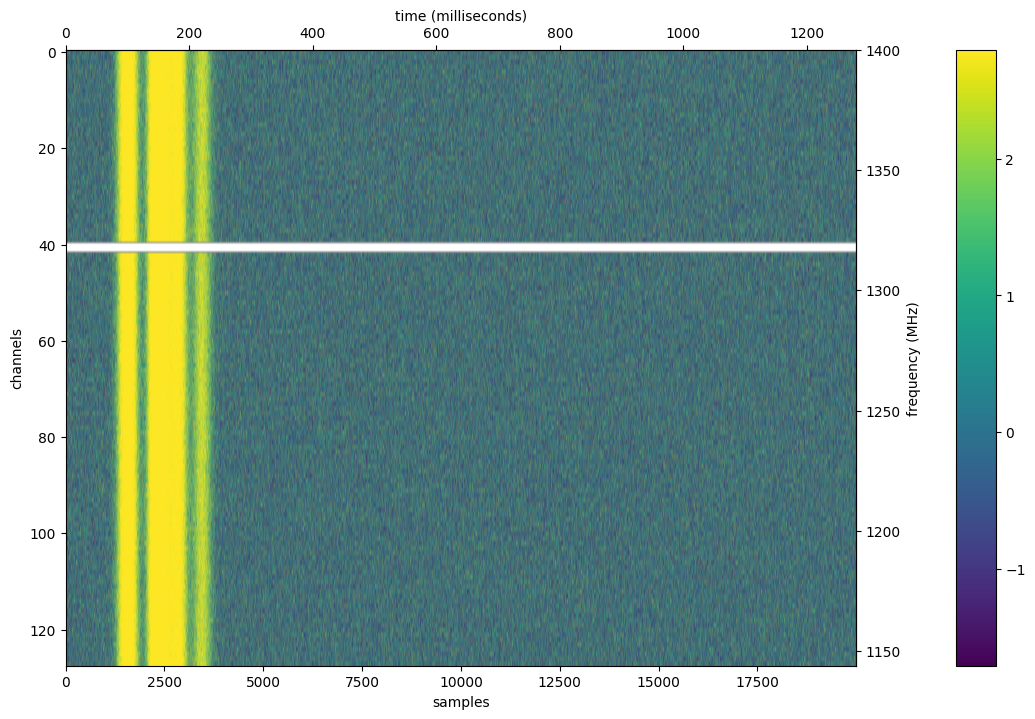

In [6]:
dmplot.waterfall(burst, dm=123.45, badchannels=[40, 41], backgroundrange=[0.5, 1]);

Currently, the plots take a `Burst` instance as the first argument. Feature versions may also take a tuple of `(data, header)`, and the actual plot functions may be implemented as methods on the `Burst` object. In the latter case, you would use `burst.waterfall(dm=123.45, badchannels=[40, 41], backgroundrange=[0.5, 1])` to create the plot.

To create a light curve, the same parameters are needed (for the bandpass correction and the dedispersion)`, for the `dmplot.lightcurve` function:

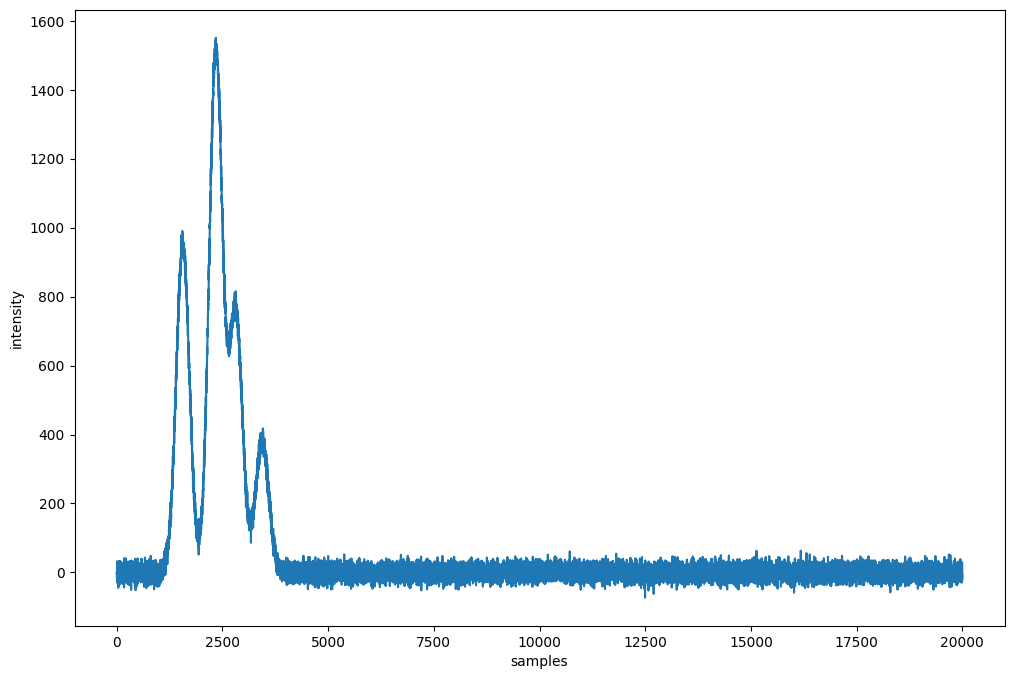

In [7]:
dmplot.lightcurve(burst, dm=123.45, badchannels=[40, 41], backgroundrange=[0.5, 1]);

Note that at the moment, there is no option to limit the data section to be used, nor an option to limit the data to be plotted.

We can set the y-scale to logarithmic. In that case, all values at or below 0 would be invalid, and the plotting routine uses a trick to plot negative values, similarly to Matplotlib's [symlog scale](https://matplotlib.org/stable/gallery/scales/symlog_demo.html). The utility can be found in `amsterdm.utils.symlog`. Alternatively, you can set a lower cutoff for the y-scale, as is done in the example below. 
Note that the y-axis is not actually plotted with a logaritmic scale

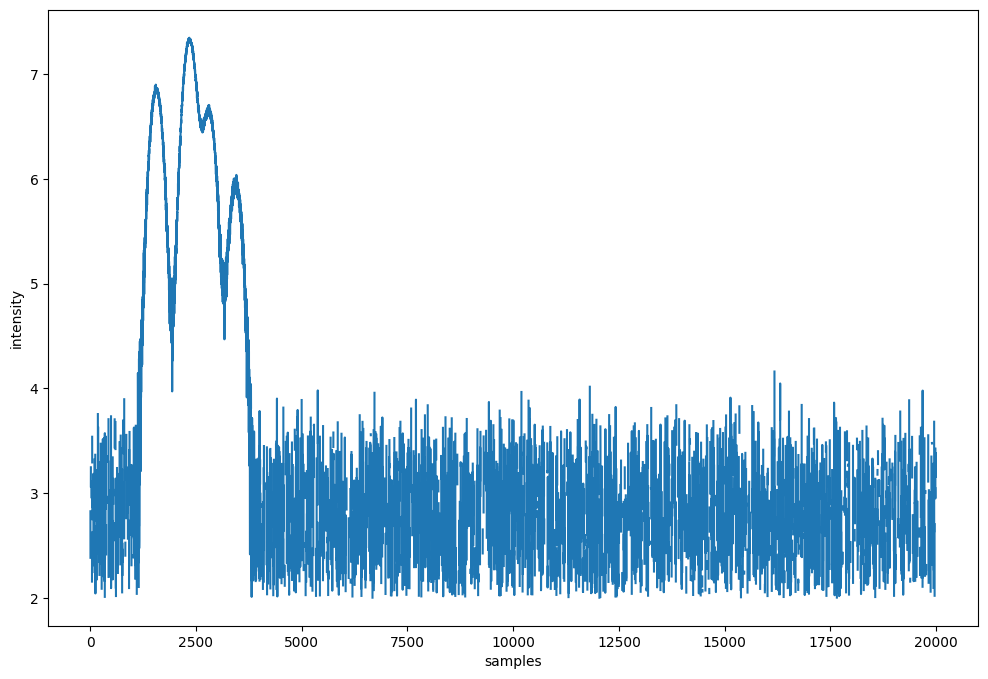

In [8]:
dmplot.lightcurve(burst, dm=123.45, badchannels=[40, 41], backgroundrange=[0.5, 1], logscale=True, ymin=2);

For future examples, let's set some variables.

In [9]:
DM = 123.45
badchannels = [40, 41]
bkgrange = [0.5, 1]

To view how well the background was estimated (for the bandpass correction), you can plot the background level together with the background standard deviation.
In this example, since it is simulated data, the background is really well behaved. Note the gap where two channels have been flagged.

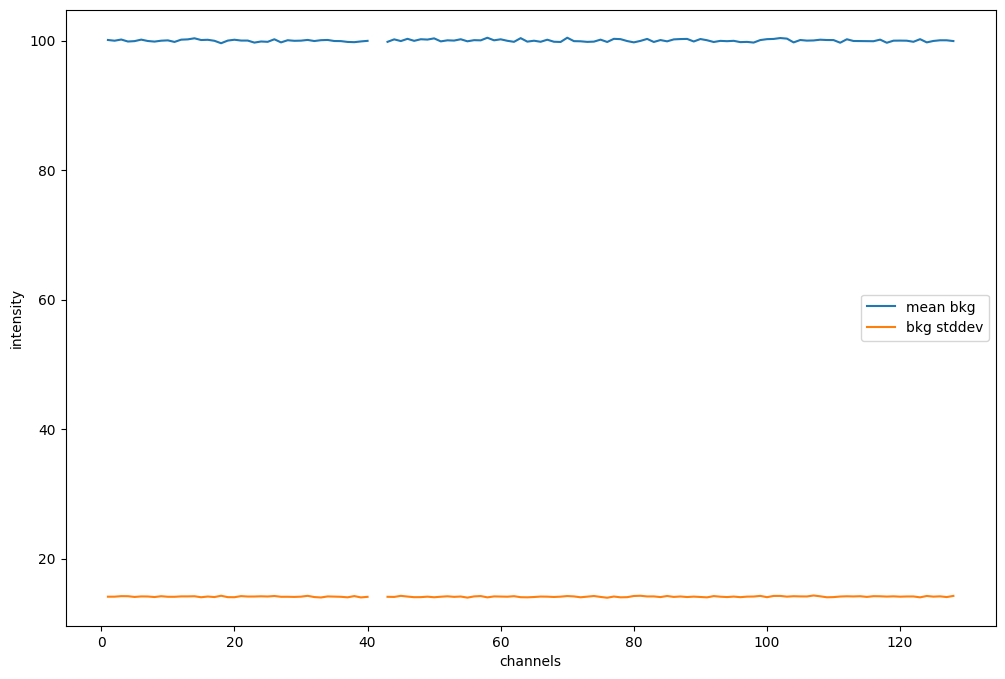

In [10]:
dmplot.background(burst, dm=DM, badchannels=badchannels, backgroundrange=bkgrange);

A signal-to-noise ratio plot can also be created. Here the sample-section of interest (which contains just the light curve) can be given with the `peak_interval` keyword argument: this should be a 2-element tuple of fraction of the total light curve.
If an interval is given, the background can still be calculated from other areas of the total sample range: the interval is mainly to speed up the calculation of the signal-to-noise.
By default, the maximum (peak) is used for the ratio; setting the `peak` keyword argument to `False` will use the full integrated light curve for the relevant interval (which is unlikely to change with changing DM).
Finally, a `dms` (dispersion measures) argument is an array of DMs to calculate the ratios for.

(<Figure size 1200x800 with 1 Axes>, <Axes: xlabel='DM', ylabel='S / N'>)

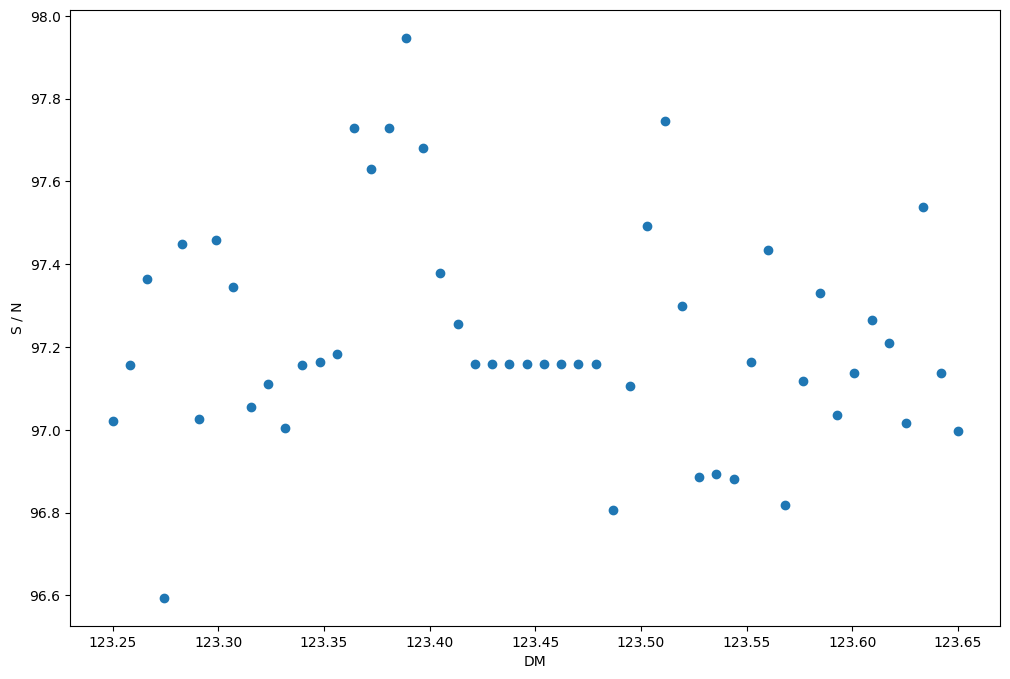

In [11]:
dms = np.linspace(DM - 0.2, DM + 0.2)
dmplot.signal2noise(burst, dms, badchannels=badchannels, backgroundrange=bkgrange, peak_interval=[0, 0.25])

Very bright bursts tend to show this flattening near the peak; it's an indication that the effective time resolution is not enough, and dedispersion by a small amount results in no actual change in the dynamical spectrum, since the shift is less than pixel width.

There is a little utility function that can try to find the sample section of the light curve automatically. The input of this utility is the actual light cruve data. To obtain that, we'll need to do some handwork, since there is not yet a method to derive the light curve data directly from a `Burst` instance. 

In [12]:
# Grab relevant information for dedispersion from the burst; `burst.freqs` is a convenience property
dm = {'dm': DM, 'freq': burst.freqs, 'tsamp': burst.header['tsamp']}
lc = amsterdm.core.calc_lightcurve(burst.data, dm=dm, badchannels=badchannels, backgroundrange=bkgrange)
lc.shape

(20000,)

`lc` is a one-dimensional array with the light curve data; the sample axis is simply a linearly increasing array (`np.arange(len(lc))`), and if you want the time stamps instead, you can use `burst.times` which is another convenience property.

To find the light curve section, use `amsterdm.core.findrangelc`. The algorithm is described in its docstring.
It returns a list of intervals where it finds an active light curve (overlapping sections being merged into one section). Since the light curve has no background gaps in this example, it finds one single section.
Note that the algorithm works well for brighter burst; it has not been tested on faint bursts.

In [13]:
sections = amsterdm.core.findrangelc(lc)
sections

[(np.int64(1007), np.int64(4062))]

The range 1007 – 4062 agrees well with the light curve plot above.

We can also plot a simple bowtie plot. Here, the input is a bit different: the dm is given as a range, with `ndm` a keyword argument on how many values to split the range into (default is 50).

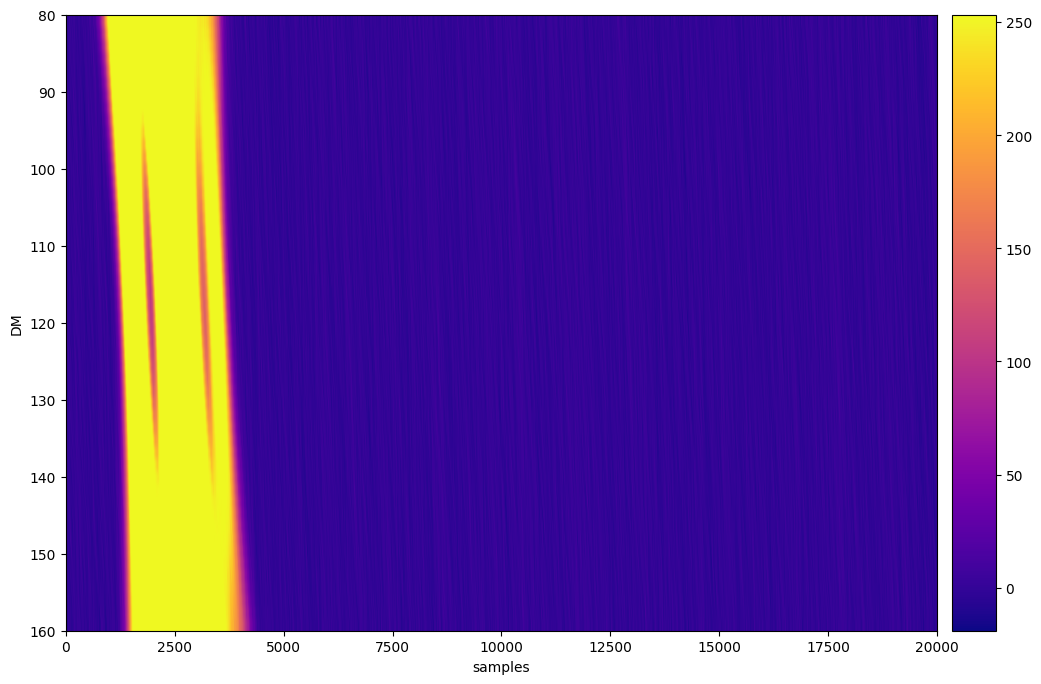

In [14]:
dmplot.bowtie(burst, dm=(80, 160), badchannels=badchannels, backgroundrange=bkgrange);

Note that with a multi-peak burst like this, the bowtie is somewhat hard to spot. With a log scale and the color range limited to the higher values, it looks as follows:

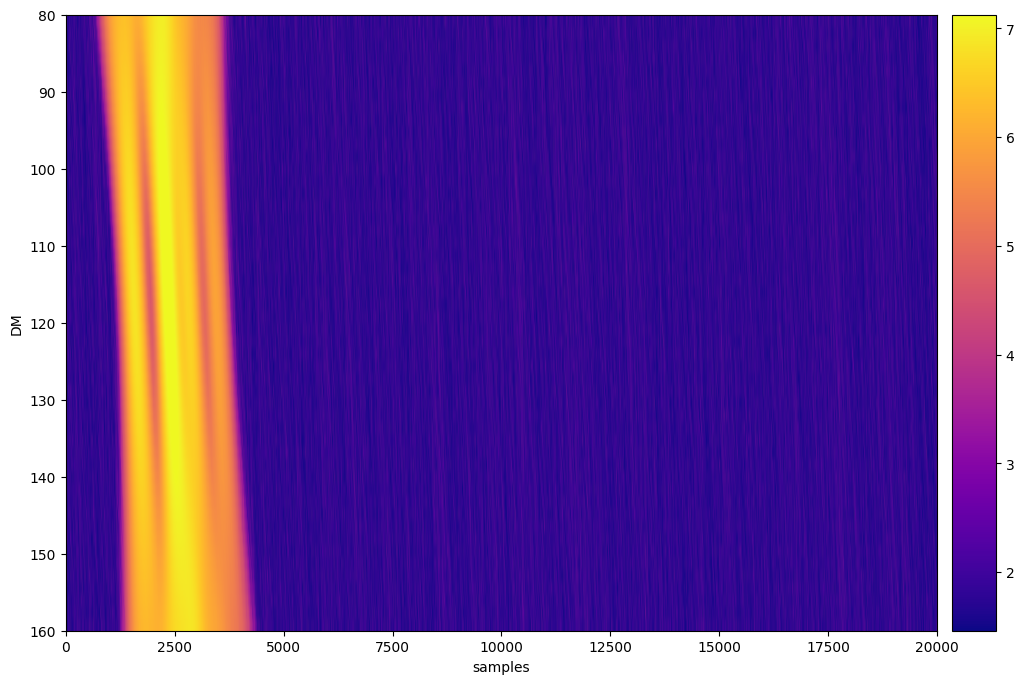

In [15]:
dmplot.bowtie(burst, dm=(80, 160), badchannels=badchannels, backgroundrange=bkgrange, logscale=True, vmin=0.5, vmax=0.995);